# Classification

## Objectives

*   Fit and evaluate a classification model to predict if a treatment will be successful or not.


## Inputs

* outputs/datasets/collection/FertilityTreatmentData.csv.gz
* Instructions from the notebooks 02 and 04 on which variables to use for data cleaning and feature engineering.

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot


---

## Change working directory

Change the working directory from its current folder to its parent folder
* Access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor/jupyter_notebooks'

To make the parent of the current directory the new current directory:
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("A new current directory has been set")

A new current directory has been set


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor'

---

## Step 1: Load Data

In [4]:
import numpy as np
import pandas as pd

# Open dataset
df = pd.read_csv("outputs/datasets/collection/FertilityTreatmentData.csv.gz")
        
print(df.shape)
df.head(3)

(169616, 61)


/var/folders/ps/q2jlnsf17tx866fp04k_jkg00000gn/T/ipykernel_13597/3215408494.py:5: DtypeWarning: Columns (4,38,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("outputs/datasets/collection/FertilityTreatmentData.csv.gz")


,Patient age at treatment,Total number of previous IVF cycles,Total number of previous DI cycles,Total number of previous pregnancies - IVF and DI,Total number of previous live births - IVF or DI,Causes of infertility - tubal disease,Causes of infertility - ovulatory disorder,Causes of infertility - male factor,Causes of infertility - patient unexplained,Causes of infertility - endometriosis,...,Heart three weeks gestation,Heart three birth outcome,Heart three birth weight,Heart three sex,Heart three birth congenital abnormalities,Heart three delivery date,Patient ethnicity,Partner ethnicity,Partner Type,Partner age
0,45-50,3,0,0.0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,Black,Other,Male,NaN
1,18-34,0,0,NaN,NaN,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,White,Other,NaN,NaN
2,999,0,0,NaN,NaN,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,Other,Other,NaN,NaN


---

## Step 2: ML Pipeline with all data

#### ML pipeline for Data Cleaning and Feature Engineering

Custom Transformers:

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin


class FilterIVFTreatments(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.query(
            "`Main reason for producing embroys storing eggs` == 'Treatment - IVF'"
        )

class DropErroneousEntries(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(
            X[(X["Live birth occurrence"] == 1) & (X["Embryos transferred"] == 0)].index
        )

class ConvertToNumeric(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            # Replace '>3' with 4
            X[col] = X[col].replace(">3", 4)
            # Convert to numeric
            X[col] = pd.to_numeric(X[col])
        return X


class ConvertToIntegers(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            # Replace '>3' with 4 and convert to int
            X[col] = X[col].replace(">3", 4).astype(float).astype(int)
        return X


class FillSpermSource(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["Sperm source"] = X.apply(self._fill_sperm_source, axis=1)
        return X

    def _fill_sperm_source(self, row):
        if pd.isna(row["Sperm source"]):
            if not pd.isna(row["Sperm donor age at registration"]):
                return "Donor"
            else:
                return "Partner"
        return row["Sperm source"]


# Convert float values to integers and handle NaN values
class ConvertToIntAndReplace999(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Fill NaN with -1 and convert to int
        X["Date of embryo transfer"] = (
            X["Date of embryo transfer"].fillna(-1).astype(int)
        )
        # Replace 999 with 0
        X["Date of embryo transfer"] = X["Date of embryo transfer"].replace(999, 0)
        return X


# Replace missing values based on the "Embryos transferred" column
class ReplaceMissingValues(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["Date of embryo transfer"] = X.apply(self._replace_missing, axis=1)
        return X

    def _replace_missing(self, row):
        value = row["Date of embryo transfer"]
        if value == -1 and row["Embryos transferred"] == 0:
            return "NT"
        elif value == -1:
            return "Missing"
        return value


# Append strings based on the "Fresh cycle" and "Frozen cycle" values
class AppendCycleType(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["Date of embryo transfer"] = X.apply(self._append_cycle_type, axis=1)
        return X

    def _append_cycle_type(self, row):
        value = row["Date of embryo transfer"]
        if value not in ["NT", "Missing"]:
            if row["Fresh cycle"] == 1:
                value = f"{value} - fresh"
            elif row["Frozen cycle"] == 1:
                value = f"{value} - frozen"
            else:
                value = f"{value} - Mixed fresh/frozen"
        return value


class MicroInjectedEmbryos(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Embryos transferred from eggs micro-injected imputation
        missing_micro_injected = X[
            "Embryos transferred from eggs micro-injected"
        ].isna()
        ICSI = X["Specific treatment type"].str.contains("ICSI")
        # Only replace missing values
        X.loc[
            missing_micro_injected & ICSI,
            "Embryos transferred from eggs micro-injected",
        ] = X.loc[missing_micro_injected & ICSI, "Embryos transferred"]
        X.loc[
            missing_micro_injected & ~ICSI,
            "Embryos transferred from eggs micro-injected",
        ] = 0

        return X


class DonorAgeImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Mapping from donor age ranges to patient/partner age ranges
        self.egg_age_map = {
            "Between 21 and 25": "18-34",
            "Between 26 and 30": "18-34",
            "Between 31 and 35": "18-34",
            ">35": "38-39",
            "<= 20": "18-34",
        }
        self.sperm_age_map = {
            "Between 21 and 25": "18-34",
            "Between 26 and 30": "18-34",
            "Between 31 and 35": "18-34",
            "Between 36 and 40": "38-39",
            "Between 41 and 45": "43-44",
            ">45": "45-50",
            "<= 20": "18-34",
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Egg donor age imputation
        X["Egg donor age at registration"] = X["Egg donor age at registration"].map(
            self.egg_age_map
        )
        missing_egg_age = (X["Egg donor age at registration"].isna()) & (
            X["Egg source"] == "Patient"
        )
        X.loc[missing_egg_age, "Egg donor age at registration"] = X.loc[
            missing_egg_age, "Patient age at treatment"
        ]
        X.rename(
            columns={"Egg donor age at registration": "Patient/Egg provider age"},
            inplace=True,
        )

        # Sperm donor age imputation
        X["Sperm donor age at registration"] = X["Sperm donor age at registration"].map(
            self.sperm_age_map
        )
        missing_sperm_age = (X["Sperm donor age at registration"].isna()) & (
            X["Sperm source"] == "Partner"
        )
        X.loc[missing_sperm_age, "Sperm donor age at registration"] = X.loc[
            missing_sperm_age, "Partner age"
        ]
        X.rename(
            columns={"Sperm donor age at registration": "Partner/Sperm provider age"},
            inplace=True,
        )

        # Ensure no duplicate columns
        if X.columns.duplicated().any():
            raise ValueError("Duplicate column names found after transformation")

        return X


class FloatToIntTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.float_vars = None

    def fit(self, X, y=None):
        # Identify float columns
        self.float_vars = X.select_dtypes(include="float").columns.tolist()
        return self

    def transform(self, X):
        X = X.copy()
        for var in self.float_vars:
            X[var] = X[var].astype(int)
        return X


class EFlaggingTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        X["Embryos transferred"] = X.apply(self.append_e, axis=1)
        return X

    def append_e(self, row):
        if (
            row["Embryos transferred"] == 1
            and row["Elective single embryo transfer"] == 1
        ):
            return "1e"
        else:
            return row["Embryos transferred"]


class TypeOfCycleAppender(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_update):
        self.columns_to_update = columns_to_update

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Ensure columns have the correct data type to avoid issues
        for column in self.columns_to_update:
            X[column] = X[column].astype(str)

        # Apply transformation for frozen cycle
        for column in self.columns_to_update:
            X.loc[(X["Frozen cycle"] == 1) & (X[column] == "0"), column] = (
                "0 - frozen cycle"
            )

        # Apply transformation for fresh cycle
        X["Total embryos thawed"] = X["Total embryos thawed"].astype(str)
        X.loc[
            (X["Fresh cycle"] == 1) & (X["Total embryos thawed"] == "0"),
            "Total embryos thawed",
        ] = "0 - fresh cycle"

        return X

#### Pipeline

In [6]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropFeatures, SmartCorrelatedSelection
from feature_engine.imputation import ArbitraryNumberImputer, DropMissingData
from feature_engine.encoding import OrdinalEncoder, OneHotEncoder

# Columns to drop
columns_to_drop = [
    "Main reason for producing embroys storing eggs",
    "Type of treatment - IVF or DI",
    "Donated embryo",
    "Eggs thawed (0/1)",
    "Year of treatment",
    "Number of live births",
    "Embryos stored for use by patient",
    "Fresh eggs stored (0/1)",
    "Heart three birth congenital abnormalities",
    "Heart two birth congenital abnormalities",
    "Heart three delivery date",
    "Heart three sex",
    "Heart three birth weight",
    "Heart three weeks gestation",
    "Heart three birth outcome",
    "Heart one birth congenital abnormalities",
    "Heart two birth weight",
    "Heart two delivery date",
    "Heart two sex",
    "Heart two weeks gestation",
    "Heart two birth outcome",
    "Heart one birth weight",
    "Heart one weeks gestation",
    "Heart one delivery date",
    "Heart one sex",
    "Heart one birth outcome",
    "Number of foetal sacs with fetal pulsation",
    "Early outcome",
    "Partner Type",
]

# Columns to be updated with the type of cycle
columns_to_update = [
    "Fresh eggs collected",
    "Total eggs mixed",
    "Total embryos created",
]

def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline(
        [
            # Data Cleaning Steps
            ("filter_ivf", FilterIVFTreatments()),
            ("drop_erroneous", DropErroneousEntries()),
            ("drop_columns", DropFeatures(features_to_drop=columns_to_drop)),
            (
                "convert_to_numeric",
                ConvertToNumeric(
                    columns=[
                        "Total number of previous pregnancies - IVF and DI",
                        "Total number of previous live births - IVF or DI",
                    ]
                ),
            ),
            (
                "zeros_imputer",
                ArbitraryNumberImputer(
                    arbitrary_number=0,
                    variables=[
                        "Total number of previous pregnancies - IVF and DI",
                        "Total number of previous live births - IVF or DI",
                    ],
                ),
            ),
            (
                "convert_to_int",
                ConvertToIntegers(
                    columns=[
                        "Total number of previous pregnancies - IVF and DI",
                        "Total number of previous live births - IVF or DI",
                    ]
                ),
            ),
            ("fill_sperm_source", FillSpermSource()),  
            ("dot_to_int_999", ConvertToIntAndReplace999()),  
            ("replace_missing_values", ReplaceMissingValues()),  
            ("append_cycle_type", AppendCycleType()),  
            ("micro_injected", MicroInjectedEmbryos()),  
            ("donor_age", DonorAgeImputer()),  
            ("float_to_int", FloatToIntTransformer()),  
            ("e_flagging", EFlaggingTransformer()),  
            ("type_of_cycle", TypeOfCycleAppender(columns_to_update=columns_to_update)),
            ("drop_missing_data", DropMissingData()),

            # Feature Engineering Steps
            (
                "ordinal_encoding",
                OrdinalEncoder(
                    encoding_method='arbitrary',
                    variables=[
                        "Patient age at treatment",
                        "Partner/Sperm provider age",
                        "Patient/Egg provider age",
                        "Total number of previous IVF cycles",
                        "Total number of previous DI cycles",
                        "Fresh eggs collected",
                        "Total eggs mixed",
                        "Total embryos created",
                        "Embryos transferred",
                        "Total embryos thawed",
                        "Date of embryo transfer",
                        "Partner age"
                    ]
                ),
            ),
            (
                "one_hot_encoding",
                OneHotEncoder(
                    variables=[
                        "Specific treatment type",
                        "Egg source",
                        "Sperm source",
                        "Patient ethnicity",
                        "Partner ethnicity",
                    ]
                ),
            ),
            ("smart_correlation", SmartCorrelatedSelection()),
        ]
    )

    return pipeline_base

PipelineDataCleaningAndFeatureEngineering()

Pipeline(steps=[('filter_ivf', FilterIVFTreatments()),
                ('drop_erroneous', DropErroneousEntries()),
                ('drop_columns',
                 DropFeatures(features_to_drop=['Main reason for producing '
                                                'embroys storing eggs',
                                                'Type of treatment - IVF or DI',
                                                'Donated embryo',
                                                'Eggs thawed (0/1)',
                                                'Year of treatment',
                                                'Number of live births',
                                                'Embryos stored for use by '
                                                'patient',
                                                'Fresh eggs stored (0/1)',
                                                'Heart th...
                                           'Total number of previous DI cycles',
                                           'Fresh eggs collected',
                                           'Total eggs mixed',
                                           'Total embryos created',
                                           'Embryos transferred',
                                           'Total embryos thawed',
                                           'Date of embryo transfer',
                                           'Partner age'])),
                ('one_hot_encoding',
                 OneHotEncoder(variables=['Specific treatment type',
                                          'Egg source', 'Sperm source',
                                          'Patient ethnicity',
                                          'Partner ethnicity'])),
                ('smart_correlation', SmartCorrelatedSelection())])

### ML Pipeline for Modelling and Hyperparameter Optimisation

In [7]:
# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
)
from xgboost import XGBClassifier


def PipelineClf(model):
    pipeline_base = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("feat_selection", SelectFromModel(model)),
            ("model", model),
        ]
    )

    return pipeline_base

Custom Class for Hyperparameter Optimisation using RandomizedSearchCV

In [8]:
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd

class HyperparameterOptimizationSearchRandomizedSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.random_searches = {}

    def fit(self, X, y, cv, n_jobs=-1, verbose=1, scoring=None, refit="f1", n_iter=100):
        for key in self.keys:
            print(
                f"\nRunning RandomizedSearchCV for {key} with {n_iter} iterations.\n"
            )

            model = PipelineClf(self.models[key])
            params = self.params[key]
            rs = RandomizedSearchCV(
                model,
                params,
                # Number of parameter settings that are sampled
                n_iter=n_iter, 
                cv=cv,
                n_jobs=n_jobs,
                verbose=verbose,
                scoring=scoring,
                refit=refit,
                random_state=0 
            )
            rs.fit(X, y)
            self.random_searches[key] = rs

    def score_summary(self, sort_by="f1", scoring=None):
        if scoring is None:
            raise ValueError("Scoring dictionary must be provided")
        
        rows = []
        for k in self.random_searches:
            params = self.random_searches[k].cv_results_["params"]
            mean_scores = {
                metric: self.random_searches[k].cv_results_[f"mean_test_{metric}"]
                for metric in scoring.keys()
            }
            
            for i in range(len(params)):
                row_data = {"estimator": k, **params[i]}
                row_data.update({f"mean_{metric}": mean_scores[metric][i] for metric in mean_scores})
                rows.append(pd.Series(row_data))
        
        df = pd.DataFrame(rows).sort_values([f"mean_{sort_by}"], ascending=False)
        return df, self.random_searches


Custom Class for Hyperparameter Optimisation using GridSearchCV

In [9]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs=-1, verbose=1, scoring=None, refit="f1"):
        for key in self.keys:
            print(
                f"\nRunning GridSearchCV for {key} with {len(self.params[key])} parameter combinations.\n"
            )

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(
                model,
                params,
                cv=cv,
                n_jobs=n_jobs,
                verbose=verbose,
                scoring=scoring,
                refit=refit,
            )
            gs.fit(X, y)
            self.grid_searches[key] = gs
            
    def score_summary(self, sort_by="f1", scoring=None):
        if scoring is None:
            raise ValueError("Scoring dictionary must be provided")
        
        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_["params"]
            mean_scores = {
                metric: self.grid_searches[k].cv_results_[f"mean_test_{metric}"]
                for metric in scoring.keys()
            }
            
            for i in range(len(params)):
                row_data = {"estimator": k, **params[i]}
                row_data.update({f"mean_{metric}": mean_scores[metric][i] for metric in mean_scores})
                rows.append(pd.Series(row_data))
        
        df = pd.DataFrame(rows).sort_values([f"mean_{sort_by}"], ascending=False)
        return df, self.grid_searches


### Split Train and Test Set

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    # Do not drop the target column here because it is needed for the pipeline
    df,
    df["Live birth occurrence"],
    test_size=0.2,
    random_state=0,
)


## Handle Target Imbalance

Apply the data cleaning and feature engineering pipeline

In [11]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)

Realign y_train indices with the transformed X_train to keep only the rows present on the dataset after the cleaning step

In [12]:
y_train = y_train.loc[X_train.index]

Apply the pipeline to the test set and realign indices on y_test

In [13]:
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
y_test = y_test.loc[X_test.index]


Drop the target column from the processed X_train and X_test

In [14]:
X_train = X_train.drop(["Live birth occurrence"], axis=1)
X_test = X_test.drop(["Live birth occurrence"], axis=1)

In [15]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(104940, 38) (104940,) (26228, 38) (26228,)


Check Train Set Target distribution

0    74793
1    30147
Name: Live birth occurrence, dtype: int64


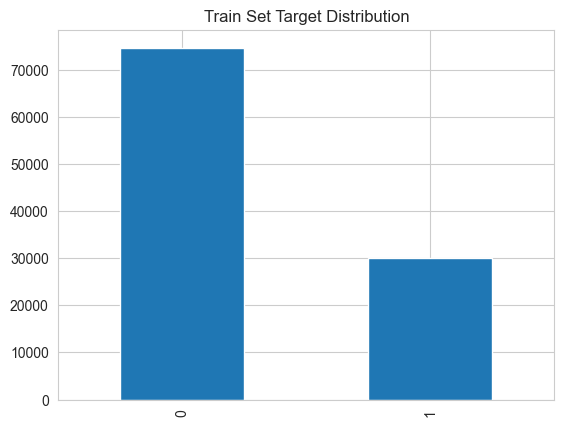

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

print(y_train.value_counts())

sns.set_style("whitegrid")
y_train.value_counts().plot(kind="bar", title="Train Set Target Distribution")
plt.show()

To address the imbalance problem, three strategies will be used to decide which one will work the best for the current dataset.

### I - Custom Handling

The first strategy is a **custom handling**, described by Peng et al. (2022) in their study "Predicting live birth in in vitro fertilization: A machine learning-based clinical prediction model using 57,558 cycles" (Frontiers in Endocrinology, 13, 838087, https://doi.org/10.3389/fendo.2022.838087) was employed.

Given that the imbalance ratio in this study was moderate, a strategy was implemented to address the imbalance without the drawbacks of traditional methods, such as information loss from undersampling or overfitting from oversampling.

The dataset will be divided into  3 sub-datasets, each maintaining a 1:1 ratio of positive to negative samples. Each sub-dataset should include all positive samples and the equivalent number of negative samples. Two sub-datasets will be have unique negative samples and since the number od negative samples is not exactly 3 times the number of positive samples, the third one will have some negative samples overlaping from the other two sub-datasets.

Decision Tree (DT) and Linear Discriminant (LD) models will be used to pre-train these sub-datasets, and key metrics like precision, recall, and F1 score will be evaluated.

The sub-dataset with the best performance metrics will then be selected and used for final model training.

#### Split Dataset into Sub-datasets

In [17]:
import pandas as pd
from sklearn.utils import resample

# Assuming X_train and y_train are your features and target respectively
X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]

# Number of positive samples
n_positive = len(X_train_1)

# Create the first sub-dataset with n_positive negative samples
X_neg_1 = resample(X_train_0, n_samples=n_positive, random_state=42, replace=False)

# Remove the selected negative samples from the pool
remaining_negatives = X_train_0.drop(X_neg_1.index)

# Create the second sub-dataset with n_positive negative samples
X_neg_2 = resample(
    remaining_negatives, n_samples=n_positive, random_state=42, replace=False
)

# Further remove the selected negatives from the pool
remaining_negatives = remaining_negatives.drop(X_neg_2.index)

# For the third sub-dataset, use all remaining negatives and resample as needed to fill
X_neg_3 = pd.concat(
    [
        remaining_negatives,
        resample(
            X_neg_1.append(X_neg_2),
            n_samples=n_positive - len(remaining_negatives),
            random_state=42,
            replace=False,
        ),
    ]
)

# Create three sub-datasets
X_sub1 = pd.concat([X_train_1, X_neg_1], axis=0)
y_sub1 = pd.concat([y_train[y_train == 1], y_train.loc[X_neg_1.index]], axis=0)

X_sub2 = pd.concat([X_train_1, X_neg_2], axis=0)
y_sub2 = pd.concat([y_train[y_train == 1], y_train.loc[X_neg_2.index]], axis=0)

X_sub3 = pd.concat([X_train_1, X_neg_3], axis=0)
y_sub3 = pd.concat([y_train[y_train == 1], y_train.loc[X_neg_3.index]], axis=0)

# Check the target distribution for each sub-dataset
print("Sub-dataset 1 distribution:\n", y_sub1.value_counts())
print("Sub-dataset 2 distribution:\n", y_sub2.value_counts())
print("Sub-dataset 3 distribution:\n", y_sub3.value_counts())

Sub-dataset 1 distribution:
 1    30147
0    30147
Name: Live birth occurrence, dtype: int64
Sub-dataset 2 distribution:
 1    30147
0    30147
Name: Live birth occurrence, dtype: int64
Sub-dataset 3 distribution:
 1    30147
0    30147
Name: Live birth occurrence, dtype: int64


/var/folders/ps/q2jlnsf17tx866fp04k_jkg00000gn/T/ipykernel_13597/1347207830.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_neg_1.append(X_neg_2),


#### Pre-train on Sub-datasets and Select the Best One

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(X_train, y_train):
    models = {
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Linear Discriminant': LinearDiscriminantAnalysis()
    }
    
    scores = {}
    
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_train)
        
        precision = precision_score(y_train, y_pred)
        recall = recall_score(y_train, y_pred)
        f1 = f1_score(y_train, y_pred)
        
        scores[model_name] = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
    
    return scores

# Evaluate each sub-dataset
scores_sub1 = evaluate_model(X_sub1, y_sub1)
scores_sub2 = evaluate_model(X_sub2, y_sub2)
scores_sub3 = evaluate_model(X_sub3, y_sub3)

# Display the results
print("Scores for Sub-dataset 1:", scores_sub1)
print("Scores for Sub-dataset 2:", scores_sub2)
print("Scores for Sub-dataset 3:", scores_sub3)


Scores for Sub-dataset 1: {'Decision Tree': {'precision': 0.8997136578544317, 'recall': 0.8963412611536803, 'f1_score': 0.898024293381632}, 'Linear Discriminant': {'precision': 0.5753656120724815, 'recall': 0.6551232295087405, 'f1_score': 0.6126595629178105}}
Scores for Sub-dataset 2: {'Decision Tree': {'precision': 0.9029533036103382, 'recall': 0.8934885726606295, 'f1_score': 0.8981960052019073}, 'Linear Discriminant': {'precision': 0.575329649445955, 'recall': 0.6527349321657213, 'f1_score': 0.6115928515928516}}
Scores for Sub-dataset 3: {'Decision Tree': {'precision': 0.9015751981539079, 'recall': 0.8942183301821077, 'f1_score': 0.8978816946442846}, 'Linear Discriminant': {'precision': 0.5762161212901715, 'recall': 0.6530334693335987, 'f1_score': 0.6122245891188407}}


In [19]:
# Compare F1 scores from both models on each sub-dataset
f1_scores = {
    'Sub1': max(scores_sub1['Decision Tree']['f1_score'], scores_sub1['Linear Discriminant']['f1_score']),
    'Sub2': max(scores_sub2['Decision Tree']['f1_score'], scores_sub2['Linear Discriminant']['f1_score']),
    'Sub3': max(scores_sub3['Decision Tree']['f1_score'], scores_sub3['Linear Discriminant']['f1_score'])
}

# Select the sub-dataset with the best F1 score
best_subdataset = max(f1_scores, key=f1_scores.get)

if best_subdataset == 'Sub1':
    X_train_custom = X_sub1
    y_train_custom = y_sub1
elif best_subdataset == 'Sub2':
    X_train_custom = X_sub2
    y_train_custom = y_sub2
else:
    X_train_custom = X_sub3
    y_train_custom = y_sub3

print(f"Best sub-dataset is {best_subdataset} with F1 score: {f1_scores[best_subdataset]}")


Best sub-dataset is Sub2 with F1 score: 0.8981960052019073


Check Train Set Target distribution after resampling

1    30147
0    30147
Name: Live birth occurrence, dtype: int64


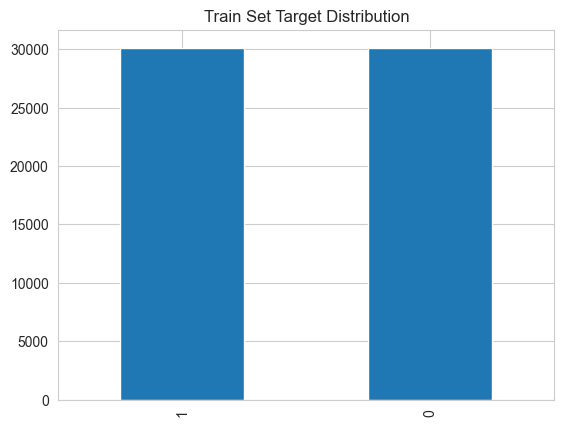

In [20]:
import matplotlib.pyplot as plt

print(y_train_custom.value_counts())

y_train_custom.value_counts().plot(kind="bar", title="Train Set Target Distribution")
plt.show()

Check Train Set Target distribution


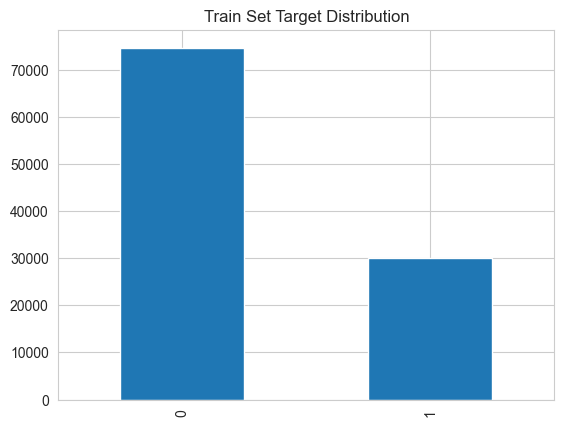

In [21]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

### II - Use SMOTE (Synthetic Minority Oversampling TEchnique) to balance Train Set target

In [22]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train_OS, y_train_OS = oversample.fit_resample(X_train, y_train)
print(X_train_OS.shape, y_train_OS.shape, X_test.shape, y_test.shape)

(149586, 38) (149586,) (26228, 38) (26228,)


Check Train Set Target distribution after resampling

1    74793
0    74793
Name: Live birth occurrence, dtype: int64


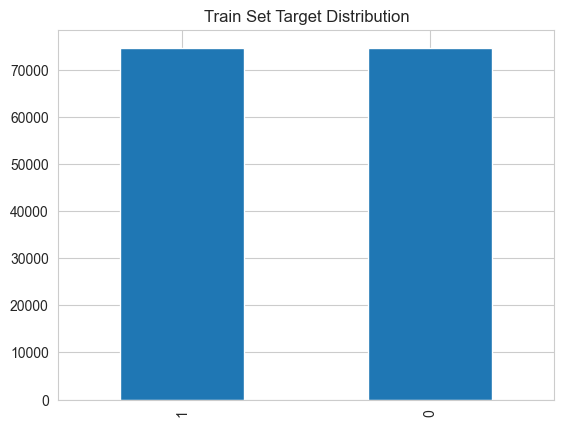

In [23]:
import matplotlib.pyplot as plt

print(y_train_OS.value_counts())

y_train_OS.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

Check Train Set Target distribution

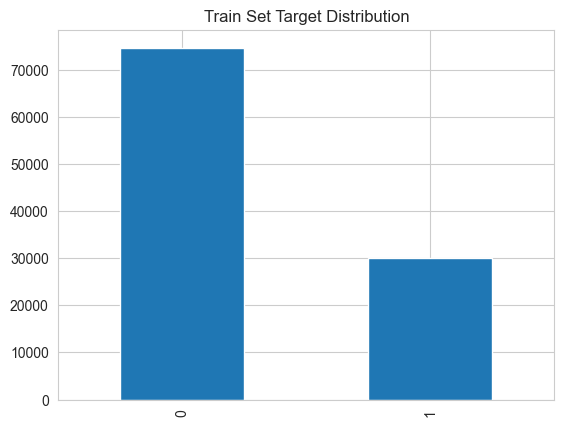

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
y_train.value_counts().plot(kind="bar", title="Train Set Target Distribution")
plt.show()

### III - Use RandomUnderSampler to balance Train Set target

In [25]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='majority', random_state=0)
X_train_US, y_train_US = undersample.fit_resample(X_train, y_train)

print(X_train_US.shape, y_train_US.shape, X_test.shape, y_test.shape)

(60294, 38) (60294,) (26228, 38) (26228,)


Check Train Set Target distribution after resampling

0    30147
1    30147
Name: Live birth occurrence, dtype: int64


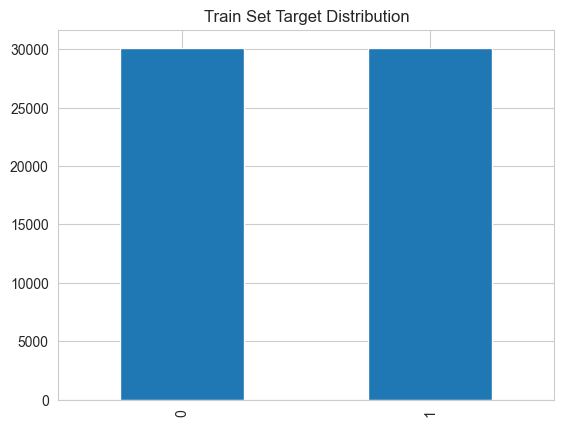

In [26]:
import matplotlib.pyplot as plt

print(y_train_US.value_counts())

y_train_US.value_counts().plot(kind="bar", title="Train Set Target Distribution")
plt.show()

## Grid Search CV - Sklearn

### Use standard hyperparameters to find most suitable algorithm 

Set Up the Models and Parameters

In [27]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
    "XGBLogitBoost": XGBClassifier(objective="binary:logistic", random_state=0)
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
    "XGBLogitBoost": {}
}

Define the custom scoring metrics

In [28]:
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, confusion_matrix

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def npv_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fn)

# Dictionary of all the metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score, pos_label=1),
    'specificity': make_scorer(specificity_score),
    'precision': make_scorer(precision_score, pos_label=1),
    'npv': make_scorer(npv_score),
    'mcc': make_scorer(matthews_corrcoef),
    'f1': make_scorer(f1_score, pos_label=1)
}

Quick GridSearch CV - Binary Classifier

### Test the three different Imbalance Handling approaches:

* Custom handling;
* Oversample;
* Undersample

#### Custom handling

In [29]:

search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)

search.fit(X_train_custom, y_train_custom, cv=5, n_jobs=-1, scoring=scoring, refit='f1')



Running GridSearchCV for LogisticRegression with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/patriciahalley/Documents/Code_institute/git/ivf-success-pred


Running GridSearchCV for XGBLogitBoost with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [30]:
# Get the results and sort by the F1 score
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='f1', scoring=scoring)
grid_search_summary


,estimator,mean_accuracy,mean_recall,mean_specificity,mean_precision,mean_npv,mean_mcc,mean_f1
4,GradientBoostingClassifier,0.644260,0.810130,0.478389,0.608347,0.715952,0.305882,0.694864
1,XGBClassifier,0.643746,0.806581,0.480910,0.608522,0.713600,0.304293,0.693584
7,XGBLogitBoost,0.643746,0.806581,0.480910,0.608522,0.713600,0.304293,0.693584
6,AdaBoostClassifier,0.641026,0.799084,0.482966,0.607210,0.706174,0.297300,0.690032
3,RandomForestClassifier,0.606445,0.684712,0.528178,0.592050,0.626191,0.215549,0.635013
5,ExtraTreesClassifier,0.602000,0.652602,0.551398,0.592626,0.613493,0.205057,0.621166
0,LogisticRegression,0.581550,0.653995,0.509105,0.571243,0.595358,0.164842,0.609818
2,DecisionTreeClassifier,0.592430,0.627392,0.557468,0.586400,0.599624,0.185440,0.606050


Get best model name programmatically

In [31]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingClassifier'

Parameters for best model

In [32]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{}

Define the best clf pipeline

In [33]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingClassifier(random_state=0))),
                ('model', GradientBoostingClassifier(random_state=0))])

In [34]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print("---  Confusion Matrix  ---")
    print(
        pd.DataFrame(
            confusion_matrix(y_true=prediction, y_pred=y),
            columns=[["Actual " + sub for sub in label_map]],
            index=[["Prediction " + sub for sub in label_map]],
        )
    )
    print("\n")

    print("---  Classification Report  ---")
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

In [35]:
print("***Performance of the best model on the custom imbalance handle strategy:***\n")

clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No Success', 'Success'] 
                )

***Performance of the best model on the custom imbalance handle strategy:***

#### Train Set #### 

---  Confusion Matrix  ---
                      Actual No Success Actual Success
Prediction No Success             36018           5741
Prediction Success                38775          24406


---  Classification Report  ---
              precision    recall  f1-score   support

  No Success       0.86      0.48      0.62     74793
     Success       0.39      0.81      0.52     30147

    accuracy                           0.58    104940
   macro avg       0.62      0.65      0.57    104940
weighted avg       0.73      0.58      0.59    104940
 

#### Test Set ####

---  Confusion Matrix  ---
                      Actual No Success Actual Success
Prediction No Success              8905           1418
Prediction Success                 9851           6054


---  Classification Report  ---
              precision    recall  f1-score   support

  No Success       0.86      0.47      0.61 

#### Oversampling

In [36]:
search.fit(X_train_OS, y_train_OS, cv=5, n_jobs=-1, scoring=scoring, refit='f1')


Running GridSearchCV for LogisticRegression with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/patriciahalley/Documents/Code_institute/git/ivf-success-pred


Running GridSearchCV for XGBLogitBoost with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [37]:
# Get the results and sort by the F1 score
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='f1', scoring=scoring)
grid_search_summary


,estimator,mean_accuracy,mean_recall,mean_specificity,mean_precision,mean_npv,mean_mcc,mean_f1
3,RandomForestClassifier,0.685305,0.798111,0.572500,0.650158,0.745503,0.382882,0.715872
5,ExtraTreesClassifier,0.681147,0.783083,0.579212,0.649519,0.731749,0.371636,0.709629
2,DecisionTreeClassifier,0.671006,0.785730,0.556282,0.638319,0.725489,0.352718,0.704071
4,GradientBoostingClassifier,0.653230,0.813553,0.492908,0.616014,0.726369,0.323904,0.701030
1,XGBClassifier,0.656866,0.797964,0.515770,0.621767,0.724709,0.329607,0.698212
7,XGBLogitBoost,0.656866,0.797964,0.515770,0.621767,0.724709,0.329607,0.698212
6,AdaBoostClassifier,0.658798,0.784526,0.533071,0.626393,0.715465,0.329471,0.696226
0,LogisticRegression,0.559230,0.477215,0.641251,0.564436,0.563326,0.122700,0.493219


Get best model name programmatically

In [38]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestClassifier'

Parameters for best model

In [39]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{}

Define the best clf pipeline

In [40]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=0))),
                ('model', RandomForestClassifier(random_state=0))])

In [41]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print("---  Confusion Matrix  ---")
    print(
        pd.DataFrame(
            confusion_matrix(y_true=prediction, y_pred=y),
            columns=[["Actual " + sub for sub in label_map]],
            index=[["Prediction " + sub for sub in label_map]],
        )
    )
    print("\n")

    print("---  Classification Report  ---")
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

In [42]:
print("***Performance of the best model on the Oversampling imbalance handle strategy:***\n")

clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No Success', 'Success'] 
                )

***Performance of the best model on the Oversampling imbalance handle strategy:***

#### Train Set #### 

---  Confusion Matrix  ---
                      Actual No Success Actual Success
Prediction No Success             48121           5004
Prediction Success                26672          25143


---  Classification Report  ---
              precision    recall  f1-score   support

  No Success       0.91      0.64      0.75     74793
     Success       0.49      0.83      0.61     30147

    accuracy                           0.70    104940
   macro avg       0.70      0.74      0.68    104940
weighted avg       0.78      0.70      0.71    104940
 

#### Test Set ####

---  Confusion Matrix  ---
                      Actual No Success Actual Success
Prediction No Success             10620           2612
Prediction Success                 8136           4860


---  Classification Report  ---
              precision    recall  f1-score   support

  No Success       0.80      0.57     

#### Undersampling

In [43]:
search.fit(X_train_US, y_train_US, cv=5, n_jobs=-1, scoring=scoring, refit='f1')


Running GridSearchCV for LogisticRegression with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/patriciahalley/Documents/Code_institute/git/ivf-success-pred


Running GridSearchCV for XGBLogitBoost with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [44]:
# Get the results and sort by the F1 score
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='f1', scoring=scoring)
grid_search_summary


,estimator,mean_accuracy,mean_recall,mean_specificity,mean_precision,mean_npv,mean_mcc,mean_f1
4,GradientBoostingClassifier,0.642551,0.815505,0.469600,0.605956,0.718409,0.304084,0.695200
1,XGBClassifier,0.642485,0.815438,0.469533,0.605887,0.718101,0.303844,0.695169
7,XGBLogitBoost,0.642485,0.815438,0.469533,0.605887,0.718101,0.303844,0.695169
6,AdaBoostClassifier,0.641639,0.799715,0.483564,0.607677,0.707618,0.298838,0.690491
3,RandomForestClassifier,0.605583,0.680731,0.530434,0.591791,0.624262,0.213595,0.633149
5,ExtraTreesClassifier,0.601702,0.650579,0.552825,0.592644,0.612747,0.204395,0.620249
0,LogisticRegression,0.580539,0.656915,0.504163,0.569864,0.595073,0.162996,0.610296
2,DecisionTreeClassifier,0.591419,0.621222,0.561614,0.586265,0.597313,0.183206,0.603180


Get best model name programmatically

In [45]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingClassifier'

Parameters for best model

In [46]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{}

Define the best clf pipeline

In [47]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingClassifier(random_state=0))),
                ('model', GradientBoostingClassifier(random_state=0))])

In [48]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print("---  Confusion Matrix  ---")
    print(
        pd.DataFrame(
            confusion_matrix(y_true=prediction, y_pred=y),
            columns=[["Actual " + sub for sub in label_map]],
            index=[["Prediction " + sub for sub in label_map]],
        )
    )
    print("\n")

    print("---  Classification Report  ---")
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

In [49]:
print("***Performance of the best model on the Undersampling imbalance handle strategy:***\n")

clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No Success', 'Success'] 
                )

***Performance of the best model on the Undersampling imbalance handle strategy:***

#### Train Set #### 

---  Confusion Matrix  ---
                      Actual No Success Actual Success
Prediction No Success             34473           5116
Prediction Success                40320          25031


---  Classification Report  ---
              precision    recall  f1-score   support

  No Success       0.87      0.46      0.60     74793
     Success       0.38      0.83      0.52     30147

    accuracy                           0.57    104940
   macro avg       0.63      0.65      0.56    104940
weighted avg       0.73      0.57      0.58    104940
 

#### Test Set ####

---  Confusion Matrix  ---
                      Actual No Success Actual Success
Prediction No Success              8508           1235
Prediction Success                10248           6237


---  Classification Report  ---
              precision    recall  f1-score   support

  No Success       0.87      0.45    

#### Choose the best alternative

Inspect and enter the best alternative for further analysis.

In [50]:
X_train, y_train = X_train_OS, y_train_OS

### Perform extensive search using RandomizedSearchCV on the most suitable algorithm to find the good hyperparameter configurations

Define model and parameters, for Extensive Search

Manually enter values for the models_search and params_search

In [51]:
# models_search = {
#     "RandomForestClassifier": RandomForestClassifier(random_state=0),
# }

# params_search = {
#     "RandomForestClassifier": {
#         "model__n_estimators": [100, 300, 500, 700, 1000],
#         "model__max_depth": [None, 10, 15, 20, 25],
#         "model__min_samples_split": [2, 10, 20],
#         "model__min_samples_leaf": [1, 2, 5, 10],
#         "model__max_features": ["sqrt", "log2", 0.5, 0.75, None],
#         "model__bootstrap": [True, False],
#         "model__class_weight": ['balanced', 'balanced_subsample', None],
#         "model__max_samples": [0.5, 0.7, 0.9, None]  # Only relevant if bootstrap=True
#     },
# }

In [52]:
# search = HyperparameterOptimizationSearchRandomizedSearch(models=models_search, params=params_search)
# search.fit(X_train, y_train, cv=5, n_jobs=-1, scoring=scoring, refit='f1', n_iter=100)

Check results

In [53]:
# grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='f1', scoring=scoring)
# grid_search_summary 

Get best model name programmatically

In [54]:
# best_model = grid_search_summary.iloc[0,0]
# best_model

Parameters for best model

In [55]:
# best_parameters = grid_search_pipelines[best_model].best_params_
# best_parameters

Define the best clf pipeline

In [56]:
# pipeline_clf = grid_search_pipelines[best_model].best_estimator_
# pipeline_clf

### Perform extensive and comprehensive search on the most suitable algorithm to find the best hyperparameter configuration using GridSearchCV

Define model and parameters, for Extensive Search

In [57]:
models_search = {
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
}

params_search = {
    "RandomForestClassifier": {
        "model__n_estimators": [300, 700, 1000],
        "model__max_depth": [None, 20, 25],
        "model__min_samples_split": [2, 10, 20],
        "model__min_samples_leaf": [2, 5, 10],
        "model__max_features": ["sqrt", "log2", 0.75],
        "model__bootstrap": [True, False],
        "model__class_weight": ['balanced', 'balanced_subsample', None],
        "model__max_samples": [0.5, 0.7, None]  # Only relevant if bootstrap=True
    },
}

Extensive GridSearch CV - Binary Classifier

In [58]:
print(y_train.value_counts())

search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, cv=5, n_jobs=-1, scoring=scoring, refit='f1')

1    74793
0    74793
Name: Live birth occurrence, dtype: int64

Running GridSearchCV for RandomForestClassifier with 8 parameter combinations.

Fitting 5 folds for each of 4374 candidates, totalling 21870 fits


/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor/venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
7290 fits failed out of a total of 21870.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7290 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor/venv/lib/pyth

Check results

In [59]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='f1', scoring=scoring)
grid_search_summary 

,estimator,model__bootstrap,model__class_weight,model__max_depth,model__max_features,model__max_samples,model__min_samples_leaf,model__min_samples_split,model__n_estimators,mean_accuracy,mean_recall,mean_specificity,mean_precision,mean_npv,mean_mcc,mean_f1
3215,RandomForestClassifier,False,balanced_subsample,20.0,sqrt,NaN,2,2,1000,0.686034,0.816722,0.555346,0.646522,0.758954,0.388338,0.721020
3296,RandomForestClassifier,False,balanced_subsample,20.0,log2,NaN,2,2,1000,0.686034,0.816722,0.555346,0.646522,0.758954,0.388338,0.721020
2567,RandomForestClassifier,False,balanced,20.0,log2,NaN,2,2,1000,0.686034,0.816722,0.555346,0.646522,0.758954,0.388338,0.721020
2486,RandomForestClassifier,False,balanced,20.0,sqrt,NaN,2,2,1000,0.686034,0.816722,0.555346,0.646522,0.758954,0.388338,0.721020
4024,RandomForestClassifier,False,None,20.0,log2,NaN,2,2,700,0.685987,0.816575,0.555400,0.646494,0.758664,0.388140,0.720977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4342,RandomForestClassifier,False,None,25.0,0.75,0.7,10,10,700,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4343,RandomForestClassifier,False,None,25.0,0.75,0.7,10,10,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4344,RandomForestClassifier,False,None,25.0,0.75,0.7,10,20,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4345,RandomForestClassifier,False,None,25.0,0.75,0.7,10,20,700,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Get best model name programmatically

In [60]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestClassifier'

Parameters for best model

In [61]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__bootstrap': False,
 'model__class_weight': 'balanced',
 'model__max_depth': 20,
 'model__max_features': 'sqrt',
 'model__max_samples': None,
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 2,
 'model__n_estimators': 1000}

Define the best clf pipeline

In [62]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=0))),
                ('model',
                 RandomForestClassifier(bootstrap=False,
                                        class_weight='balanced', max_depth=20,
                                        min_samples_leaf=2, n_estimators=1000,
                                        random_state=0))])

## Assess feature importance

In [63]:
X_train.head(3)

,Patient age at treatment,Total number of previous IVF cycles,Total number of previous DI cycles,Total number of previous pregnancies - IVF and DI,Causes of infertility - tubal disease,Causes of infertility - ovulatory disorder,Causes of infertility - male factor,Causes of infertility - patient unexplained,Causes of infertility - endometriosis,Patient/Egg provider age,...,Patient ethnicity_White,Patient ethnicity_Mixed,Patient ethnicity_Asian,Patient ethnicity_Black,Patient ethnicity_Other,Partner ethnicity_White,Partner ethnicity_Other,Partner ethnicity_Any other ethnicity,Partner ethnicity_Black,Partner ethnicity_Mixed
0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
1,1,1,0,0,0,0,0,1,0,1,...,1,0,0,0,0,1,0,0,0,0
2,1,2,0,0,1,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0


Assess feature importance on the current model with `.features_importances_`

* These are the 11 most important features in descending order. The model was trained on them: 
['Date of embryo transfer', 'Embryos transferred', 'Partner age', 'Total number of previous IVF cycles', 'Patient/Egg provider age', 'Patient age at treatment', 'Fresh eggs collected', 'Total embryos created', 'Total eggs mixed', 'Total number of previous pregnancies - IVF and DI', 'Causes of infertility - male factor']


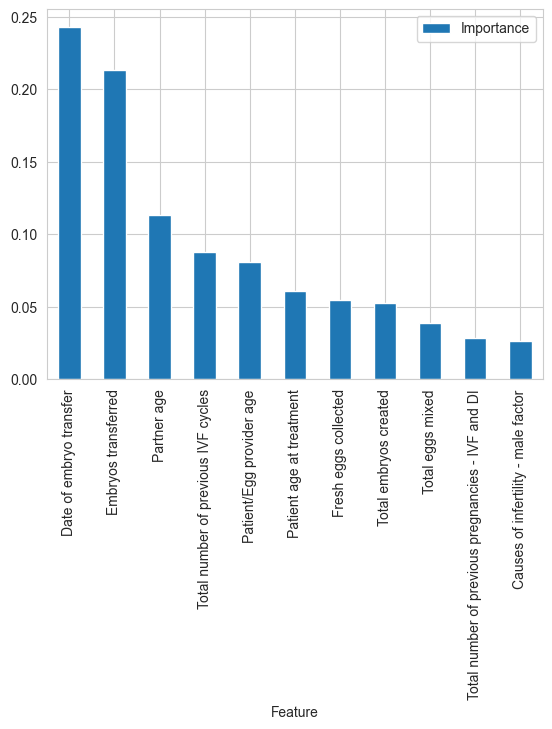

In [64]:
# create DataFrame to display feature importance
df_feature_importance = pd.DataFrame(
    data={
        "Feature": X_train.columns[pipeline_clf["feat_selection"].get_support()],
        "Importance": pipeline_clf["model"].feature_importances_,
    }
).sort_values(by="Importance", ascending=False)

# re-assign best_features order
best_features = df_feature_importance["Feature"].to_list()

# Most important features statement and plot
print(
    f"* These are the {len(best_features)} most important features in descending order. "
    f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}"
)

df_feature_importance.plot(kind="bar", x="Feature", y="Importance")
plt.show()

## Evaluate Pipeline on Train and Test Sets

In [65]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print("---  Confusion Matrix  ---")
    print(
        pd.DataFrame(
            confusion_matrix(y_true=prediction, y_pred=y),
            columns=[["Actual " + sub for sub in label_map]],
            index=[["Prediction " + sub for sub in label_map]],
        )
    )
    print("\n")

    print("---  Classification Report  ---")
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

Evaluation:

In [66]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No Success', 'Success'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                      Actual No Success Actual Success
Prediction No Success             45866           9261
Prediction Success                28927          65532


---  Classification Report  ---
              precision    recall  f1-score   support

  No Success       0.83      0.61      0.71     74793
     Success       0.69      0.88      0.77     74793

    accuracy                           0.74    149586
   macro avg       0.76      0.74      0.74    149586
weighted avg       0.76      0.74      0.74    149586
 

#### Test Set ####

---  Confusion Matrix  ---
                      Actual No Success Actual Success
Prediction No Success             10326           2364
Prediction Success                 8430           5108


---  Classification Report  ---
              precision    recall  f1-score   support

  No Success       0.81      0.55      0.66     18756
     Success       0.38      0.68      0.49      7472

    accuracy 